<a href="https://colab.research.google.com/github/insafhamdi/Car-Insurance/blob/main/Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Read in dataset
cars = pd.read_csv("/car_insurance.csv")

# Check for missing values
cars.info()

# Fill missing values with the mean
cars["credit_score"].fillna(cars["credit_score"].mean(), inplace=True)
cars["annual_mileage"].fillna(cars["annual_mileage"].mean(), inplace=True)

# Empty list to store model results
models = []

# Feature columns
features = cars.drop(columns=["id", "outcome"]).columns

# Loop through features
for col in features:
    # Create a model
    model = logit(f"outcome ~ {col}", data=cars).fit()
    # Add each model to the models list
    models.append(model)

# Empty list to store accuracies
accuracies = []

# Loop through models
for feature in range(0, len(models)):
    # Compute the confusion matrix
    conf_matrix = models[feature].pred_table()
    # True negatives
    tn = conf_matrix[0,0]
    # True positives
    tp = conf_matrix[1,1]
    # False negatives
    fn = conf_matrix[1,0]
    # False positives
    fp = conf_matrix[0,1]
    # Compute accuracy
    acc = (tn + tp) / (tn + fn + fp + tp)
    accuracies.append(acc)

# Find the feature with the largest accuracy
best_feature = features[accuracies.index(max(accuracies))]

# Create best_feature_df
best_feature_df = pd.DataFrame({"best_feature": best_feature,
                                "best_accuracy": max(accuracies)},
                                index=[0])
best_feature_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

,best_feature,best_accuracy
0,driving_experience,0.7771


## 1. Préparation de la base


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer



# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
cars['credit_score'] = imputer.fit_transform(cars[['credit_score']])
cars['annual_mileage'] = imputer.fit_transform(cars[['annual_mileage']])

# Encodage des variables catégorielles
label_encoder = LabelEncoder()
categorical_vars = ['gender', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'vehicle_type', 'postal_code']
for col in categorical_vars:
    cars[col] = label_encoder.fit_transform(cars[col])

# Affichage des premières lignes pour vérifier
print(cars.head())



       id  age  gender  driving_experience  education  income  credit_score  \
0  569520    3       0                   0          0       2      0.629027   
1  750365    0       1                   0          1       1      0.357757   
2  199901    0       0                   0          0       3      0.493146   
3  478866    0       1                   0          2       3      0.206013   
4  731664    1       1                   1          1       3      0.388366   

   vehicle_ownership  vehicle_year  married  children  postal_code  \
0                  1             0        0       1.0            0   
1                  0             1        0       0.0            0   
2                  1             1        0       0.0            0   
3                  1             1        0       1.0            2   
4                  1             1        0       0.0            2   

   annual_mileage  vehicle_type  speeding_violations  duis  past_accidents  \
0         12000.0         

## 2. Equilibrage des données

In [6]:
from imblearn.over_sampling import SMOTE

# Vérifier l'équilibre des classes
balance = cars['outcome'].value_counts(normalize=True)
print(balance)

# Appliquer SMOTE si déséquilibré
if balance.min() < 0.4:  # Utiliser un seuil de 0.4 comme exemple
    smote = SMOTE(random_state=42)
    X = cars.drop('outcome', axis=1)
    y = cars['outcome']
    X_sm, y_sm = smote.fit_resample(X, y)
    data_smote = pd.concat([X_sm, y_sm], axis=1)
else:
    data_smote = cars

# Affichage des nouvelles proportions
print(data_smote['outcome'].value_counts(normalize=True))



outcome
0.0    0.6867
1.0    0.3133
Name: proportion, dtype: float64
outcome
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## 4.Séléction des variables

### a. SelectKBest

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

# Préparation des données
X = cars.drop('outcome', axis=1)
y = cars['outcome']

# Sélection des k meilleures caractéristiques
selector = SelectKBest(score_func=f_classif, k=5)  # Sélectionner 5 meilleures caractéristiques
X_new = selector.fit_transform(X, y)

# Afficher les caractéristiques sélectionnées
selected_features = X.columns[selector.get_support(indices=True)]
print("SelectKBest selected features:", selected_features)


SelectKBest selected features: Index(['age', 'driving_experience', 'credit_score', 'vehicle_ownership',
       'past_accidents'],
      dtype='object')


### b. RFECV

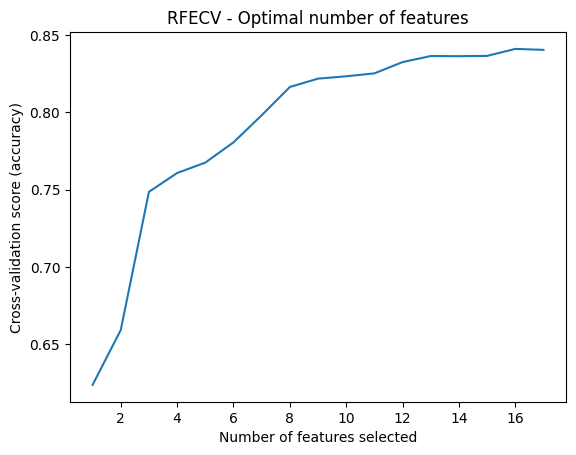

In [12]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier  # Assuming you're using RandomForest as estimator

# Assuming 'X' and 'y' are your features and target arrays respectively
estimator = RandomForestClassifier()
rfecv = RFECV(estimator, step=1, cv=5)
rfecv.fit(X, y)

# Plotting the number of features vs. cross-validation scores
plt.figure()
plt.title("RFECV - Optimal number of features")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()



## 5) Tuning des modèles
### a. Régression Logistique (RL)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres
param_grid_lr = {
    'C': [0.1, 1, 10],  # Inverse de la force de régularisation
    'penalty': ['l2'],  # L1 entraîne des erreurs sous certaines versions de scikit-learn
    'solver': ['lbfgs', 'sag', 'saga']  # Solvers différents
}

# Initialiser le modèle de Régression Logistique
logreg = LogisticRegression(max_iter=10000)

# GridSearchCV
grid_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour RL:", grid_lr.best_params_)
print("Meilleur score pour RL:", grid_lr.best_score_)


Meilleurs paramètres pour RL: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score pour RL: 0.7307


### b. Arbre de décision

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Définir la grille de paramètres
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser l'Arbre de décision
decision_tree = DecisionTreeClassifier()

# GridSearchCV
grid_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour l'Arbre:", grid_dt.best_params_)
print("Meilleur score pour l'Arbre:", grid_dt.best_score_)


Meilleurs paramètres pour l'Arbre: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Meilleur score pour l'Arbre: 0.8301999999999999


### c. Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Définir la grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser le Random Forest
random_forest = RandomForestClassifier()

# GridSearchCV
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour RF:", grid_rf.best_params_)
print("Meilleur score pour RF:", grid_rf.best_score_)


Meilleurs paramètres pour RF: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Meilleur score pour RF: 0.8483


**Régression Logistique :**

Score: 0.7307
Paramètres: Régularisation L2 avec un paramètre de pénalité C de 0.1.
Commentaire: Offre des performances acceptables avec une bonne gestion du surajustement grâce à la régularisation.

**Arbre de décision :**

Score: 0.8302
Paramètres: Profondeur maximale de 10, avec un minimum de 10 échantillons par feuille.
Commentaire: Meilleure performance que la RL, équilibrant bien le biais et la variance, et évitant le surajustement avec des contraintes sur la croissance de l’arbre.

**Random Forest :**

Score: 0.8483
Paramètres: 50 arbres, profondeur maximale de 30, 1 échantillon par feuille et 20 échantillons requis pour un split.
Commentaire: Meilleure performance des trois, indiquant une excellente capacité à généraliser les données. Plus complexe et potentiellement plus coûteux en calcul.

**Conclusion:**

Le Random Forest s'est révélé être le modèle le plus performant, suivi de près par l'Arbre de décision. Ces modèles sont préférables pour leurs capacités à capturer des relations complexes dans les données. Le choix final du modèle pourrait dépendre des ressources disponibles et des exigences spécifiques en termes de vitesse et de coût de calcul. Il est recommandé de continuer à surveiller et à mettre à jour les modèles avec de nouvelles données pour maintenir leur efficacité.






